In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import numpy as np
from pathlib import Path
from torchsummary import summary
torch.set_printoptions(sci_mode=False)

In [2]:
PATH = Path("dataset") / "GTSRB" / "Training"
torch.set_float32_matmul_precision('high')
LABELS = ["20 km/h"
,"30 km/h"
,"50 km/h"
,"60 km/h"
,"70 km/h"
,"80 km/h"
,"End of speed limit"
,"100 km/h"
,"120 km/h"
,"No passing"
,"No passing for large vehicles"
,"Right of way"
,"Priority road"
,"Yield"
,"Stop"
,"No vehicles"
,"Large vehicles prohibited"
,"No entry"
,"General caution"
,"Dangerous curve to the left"
,"Dangerous curve to the right"
,"Double curve"
,"Bumpy road"
,"Slippery road"
,"Road narrows"
,"Road work"
,"Traffic signals"
,"Pedestrians"
,"Children crossing"
,"Bicycle crossing"
,"Ice warning"
,"Wild animals crossing"
,"End of all speed and passing limits"
,"Turn right ahead"
,"Turn left ahead"
,"Ahead only"
,"Go straight or right"
,"Go straight or left"
,"Keep right"
,"Keep left"
,"Roundabout mandatory"
,"End of no passing"
,"End of no passing by large vehicles"]

In [3]:
_N = 32
batch_size = 256
n_classes = 43
epochs = 30
device = "cuda"#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def get_mean_std():
    transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    ])
    dataset = torchvision.datasets.ImageFolder(root=PATH,transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total = 0
    for images,_ in dataloader: # load a batch at a time
        n = images.size(0)
        total += 1
        mean  += images.mean(dim=[0,2,3])
        std   += images.std(dim=[0,2,3])
    std  /= total
    mean /= total
    return mean,std
# get_mean_std() # (tensor([0.3397, 0.3117, 0.3210]), tensor([0.2299, 0.2247, 0.2332]))

In [5]:
mean = torch.tensor([0.3397, 0.3117, 0.3210])
std = torch.tensor([0.2299, 0.2247, 0.2332])

def to_image(img): # convert to unormalized form for viewing
    _mean = mean.view(3,1,1)
    _std = std.view(3,1,1)
    return (img * _std + _mean).permute(1,2,0).numpy()
normalise = transforms.Normalize(mean, std)
transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    normalise
])

In [6]:
dataset = torchvision.datasets.ImageFolder(root=PATH, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           num_workers=6,
                                           shuffle=True
                                           )
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          num_workers=6,
                                          shuffle=False
                                          )

20 km/h


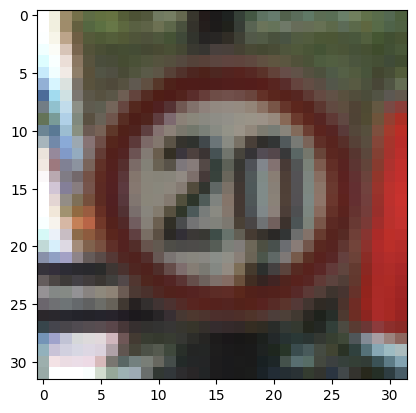

In [7]:
for img,label in train_loader:
    img = to_image(img[0])
    plt.imshow(img)
    print(LABELS[label[0]])
    break

In [8]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        x = torch.zeros((64,3,_N,_N))
        self.activation = torch.nn.functional.relu
        self.pool = torch.nn.MaxPool2d(2,2)

        self.conv1 = torch.nn.Conv2d(3,6,5)
        x = self.pool(self.activation(self.conv1(x)))
        
        self.conv2 = torch.nn.Conv2d(x.shape[1],16,5)
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        self.dense1 = torch.nn.Linear(x.shape[1],128)
        x = self.activation(self.dense1(x))
        self.dense2 = torch.nn.Linear(x.shape[1],64)
        x = self.activation(self.dense2(x))
        self.final = torch.nn.Linear(x.shape[1],n_classes)


    def forward(self,x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        
        x = torch.flatten(x, start_dim=1)

        x = self.activation(self.dense1(x))
        x = self.activation(self.dense2(x))
        x = self.final(x)

        return x
        
model = torch.compile(Model()).to(device)
summary(model,(3,32,32),batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [256, 6, 28, 28]             456
         MaxPool2d-2           [256, 6, 14, 14]               0
            Conv2d-3          [256, 16, 10, 10]           2,416
         MaxPool2d-4            [256, 16, 5, 5]               0
            Linear-5                 [256, 128]          51,328
            Linear-6                  [256, 64]           8,256
            Linear-7                  [256, 43]           2,795
             Model-8                  [256, 43]               0
Total params: 65,251
Trainable params: 65,251
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/backward pass size (MB): 15.93
Params size (MB): 0.25
Estimated Total Size (MB): 19.18
----------------------------------------------------------------


In [9]:
loss_func = torch.nn.CrossEntropyLoss().to(device)
optimiser = torch.optim.Adam(model.parameters())#torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

In [10]:
len(test_loader)

31

In [11]:

def train(model,loss_func,optimiser):
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} --- Training Loss {total_loss / len(train_loader):.3f} --- Validation Loss {test_performance(model,loss_func):.3f}")

def test_performance(model,loss_func):
    loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            loss += loss_func(preds,labels).item()
    return loss / len(test_loader)

In [12]:
train(model,loss_func,optimiser)

Epoch 1 --- Training Loss 2.631 --- Validation Loss 1.377
Epoch 2 --- Training Loss 0.922 --- Validation Loss 0.665
Epoch 3 --- Training Loss 0.513 --- Validation Loss 0.438
Epoch 4 --- Training Loss 0.337 --- Validation Loss 0.322
Epoch 5 --- Training Loss 0.247 --- Validation Loss 0.253
Epoch 6 --- Training Loss 0.196 --- Validation Loss 0.215
Epoch 7 --- Training Loss 0.156 --- Validation Loss 0.177
Epoch 8 --- Training Loss 0.129 --- Validation Loss 0.173
Epoch 9 --- Training Loss 0.108 --- Validation Loss 0.140
Epoch 10 --- Training Loss 0.085 --- Validation Loss 0.133
Epoch 11 --- Training Loss 0.079 --- Validation Loss 0.126
Epoch 12 --- Training Loss 0.063 --- Validation Loss 0.115
Epoch 13 --- Training Loss 0.055 --- Validation Loss 0.105
Epoch 14 --- Training Loss 0.047 --- Validation Loss 0.107
Epoch 15 --- Training Loss 0.042 --- Validation Loss 0.106
Epoch 16 --- Training Loss 0.040 --- Validation Loss 0.105
Epoch 17 --- Training Loss 0.036 --- Validation Loss 0.116
Epoch 

In [13]:
def evaluate(model):
    predictions = []
    labels = []
    with torch.no_grad():
        for images,lbls in test_loader:
            labels.extend(lbls.numpy())
            
            images = images.to(device)
            preds = model(images)
            predictions.extend(preds.cpu().numpy())
            
    labels = np.array(labels)
    predictions = np.array(predictions)
    pred_class = np.argmax(predictions,axis=1)
    precision = precision_score(labels, pred_class, average="weighted")
    recall = recall_score(labels, pred_class, average="weighted")
    f1 = f1_score(labels, pred_class, average="weighted")
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')
evaluate(model)

Precision (macro): 0.9858
Recall (macro): 0.9856
F1-score (macro): 0.9856


In [14]:
@torch.compile
def pgd_attack(model,images,labels,loss_func,iterations,epsilon,alpha):
    
    adversarial = denormalise(images)
    lower_bound = adversarial - epsilon
    upper_bound = adversarial + epsilon
    
    decay = torch.logspace(alpha,1,iterations,2)
    decay = decay / decay[0]

    for alpha in decay:
        normalised = normalise(adversarial)
        normalised.requires_grad = True
        model.zero_grad()
        pred = model(normalised)
        loss = loss_func(pred,labels)
        #print(loss.item())
        loss.backward()
        # TODO - Edit Learning Rate / Apply Adam Optimiser
        perturbations = torch.sign(normalised.grad.data) * epsilon * alpha
        adversarial += perturbations
        adversarial = torch.clip(adversarial,lower_bound, upper_bound)
        adversarial = torch.clip(adversarial,0,1)

    return normalise(adversarial)

normalise.to(device)

@torch.compile
def denormalise(images):
    _mean = mean.view(1,3,1,1).to(device)
    _std = std.view(1,3,1,1).to(device)
    return images * _std + _mean

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.70980394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.7294118].


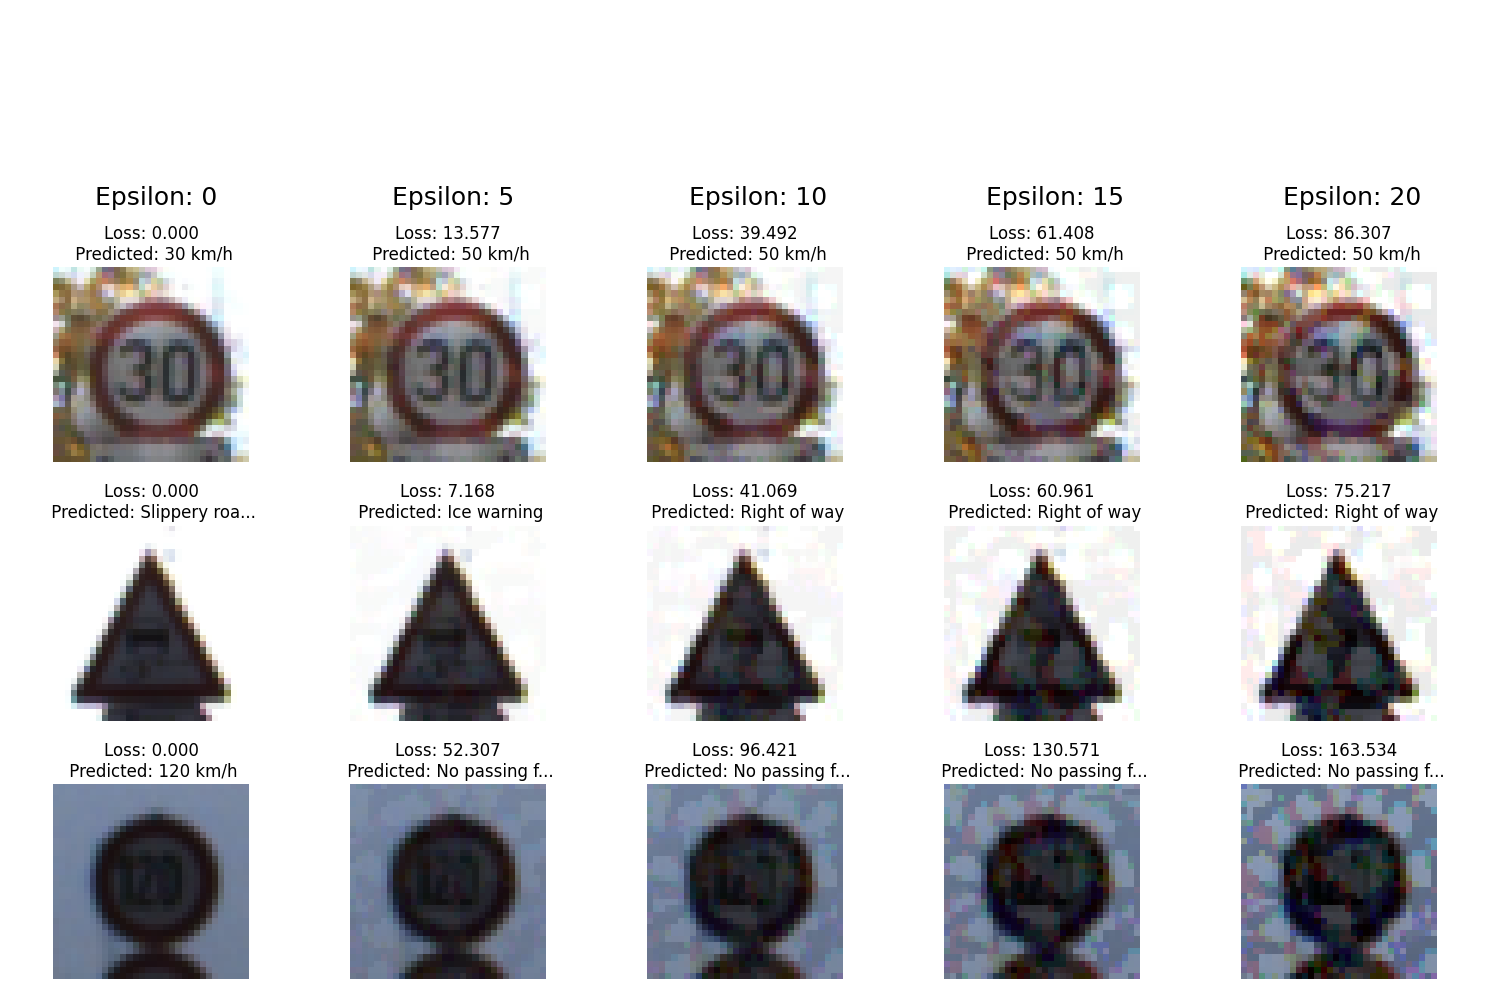

In [15]:
def adversarial_test(model):
    for img,lbl in test_loader:
        img = img.to(device)
        lbl = lbl.to(device)

        """og_pred = model(img)
        adv_pred = model(adv)
        og_loss = loss_func()"""
        #print(f"Set: {epsilon}\nActual: {torch.max(denormalise(img)-denormalise(adv))}")

        rows = 4
        columns = 5
        
        plt.figure(figsize=(15, 10))
        multiplier = 5
        for j in range(columns):
            epsilon = j * multiplier
            plt.subplot(rows, columns, j + 1)
            plt.axis("off")
            plt.text(0.3, 0, f"Epsilon: {epsilon}", fontsize=18)

            

        for j in range(columns):
            epsilon = j * multiplier / 255
            adv = pgd_attack(model,img,lbl,loss_func,50,epsilon,2)
            for i in range(1,rows):
                plt.subplot(rows, columns, i * columns + j + 1)
                pred = model(adv[i].reshape(1,3,_N,_N))
                loss = loss_func(pred,lbl[i].reshape(1)).data
                pred_class = LABELS[torch.argmax(pred)]
                pred_class = pred_class[:12] + "..." if len(pred_class) > 12 else pred_class
                plt.imshow(to_image(adv[i].cpu()))
                plt.title(f"Loss: {loss:.3f}\n Predicted: {pred_class}")
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        # Gets errors for images being out of 0-1 range, probably floating point inaccuracy
        break
adversarial_test(model)

In [16]:
xyz = torch.tensor([1,2,3,4])
xyz = torch.cat((xyz,torch.tensor([5,6,7])))
xyz

tensor([1, 2, 3, 4, 5, 6, 7])

In [17]:
def adversarial_training(model,loss_func,optimiser,iterations,epsilon,alpha):
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            images = torch.cat((images,
                pgd_attack(model,images,labels,loss_func,iterations,epsilon,alpha)
                ))
            labels = torch.cat((labels,labels))

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} --- Training Loss {total_loss / len(train_loader):.3f} --- Validation Loss {test_performance(model,loss_func):.3f}")


In [23]:
adversarial_model = torch.compile(Model()).to(device)
adv_optimiser = torch.optim.SGD(adversarial_model.parameters(),lr=0.01, momentum=0.9)

In [24]:
epochs = 60
adversarial_training(adversarial_model,loss_func,adv_optimiser,20,10/255,2) # 20 mins -> 60 epochs

Epoch 1 --- Training Loss 3.657 --- Validation Loss 3.418
Epoch 2 --- Training Loss 3.376 --- Validation Loss 3.044
Epoch 3 --- Training Loss 2.742 --- Validation Loss 1.970
Epoch 4 --- Training Loss 2.170 --- Validation Loss 1.435
Epoch 5 --- Training Loss 1.924 --- Validation Loss 1.231
Epoch 6 --- Training Loss 1.782 --- Validation Loss 1.099
Epoch 7 --- Training Loss 1.681 --- Validation Loss 0.979
Epoch 8 --- Training Loss 1.614 --- Validation Loss 0.944
Epoch 9 --- Training Loss 1.561 --- Validation Loss 0.889
Epoch 10 --- Training Loss 1.511 --- Validation Loss 0.844
Epoch 11 --- Training Loss 1.479 --- Validation Loss 0.808
Epoch 12 --- Training Loss 1.443 --- Validation Loss 0.798
Epoch 13 --- Training Loss 1.414 --- Validation Loss 0.742
Epoch 14 --- Training Loss 1.384 --- Validation Loss 0.743
Epoch 15 --- Training Loss 1.355 --- Validation Loss 0.709
Epoch 16 --- Training Loss 1.339 --- Validation Loss 0.680
Epoch 17 --- Training Loss 1.318 --- Validation Loss 0.674
Epoch 

In [25]:
evaluate(adversarial_model)

Precision (macro): 0.9340
Recall (macro): 0.9246
F1-score (macro): 0.9246


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.7058824].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.7254902].


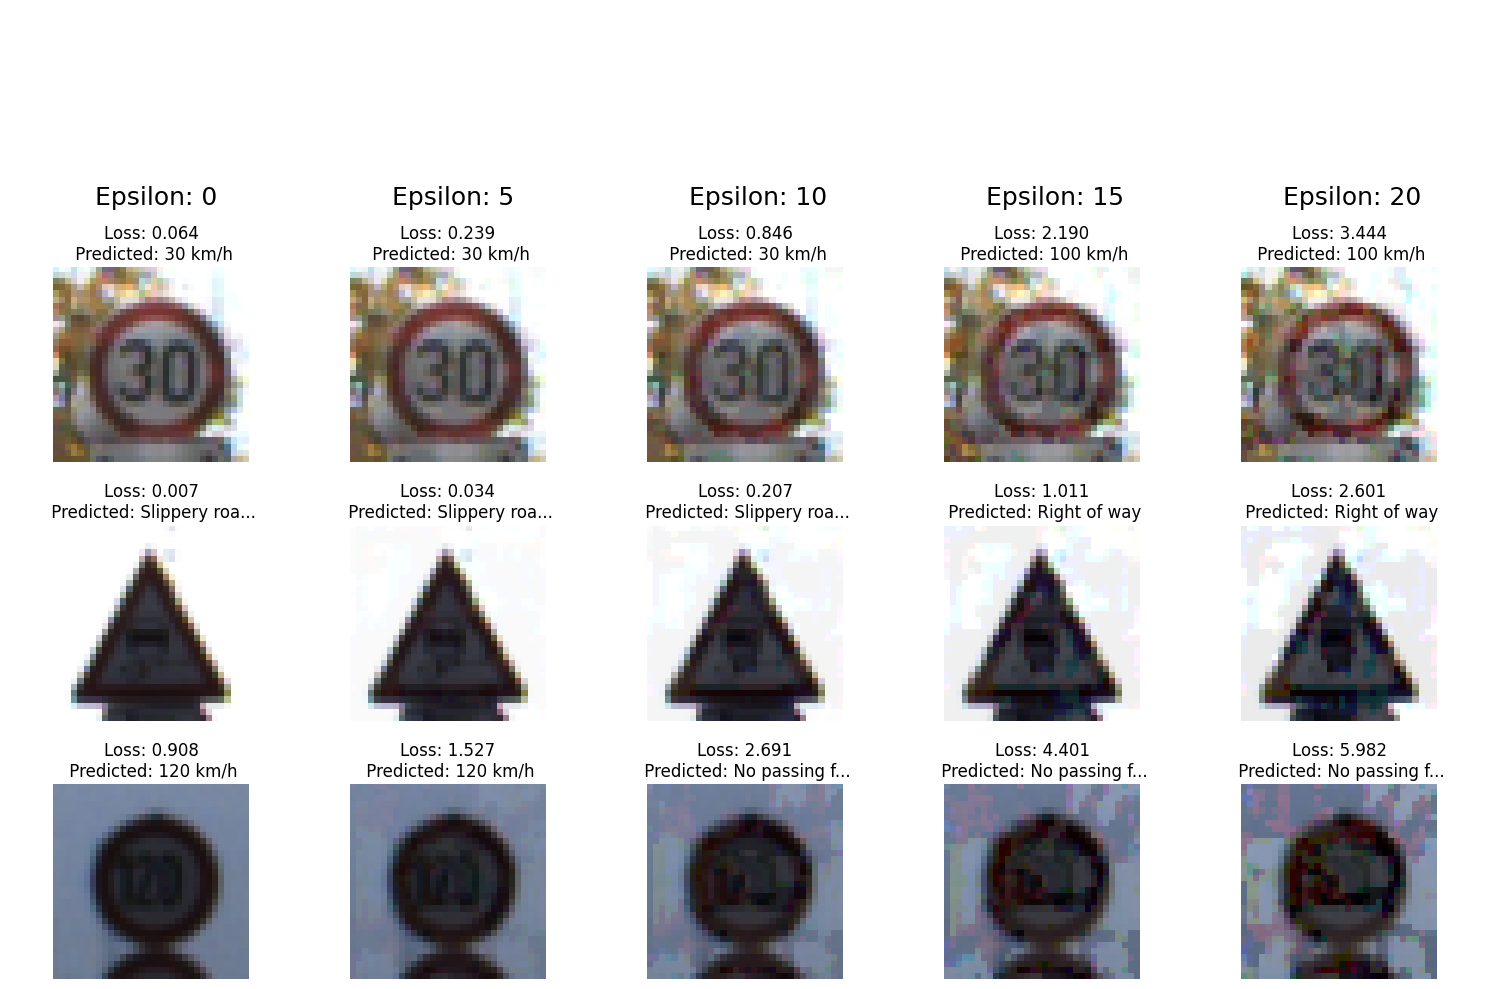

In [26]:
adversarial_test(adversarial_model)

In [27]:
torch.save(adversarial_model.state_dict(),"models/adversarial_model")